In [2]:
# Proyecto inicial Retail Fashion
# preprocesamiento.py

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Cargar datos y procesar CSV de Kaggle
df = pd.read_csv(
    "C:/Users/kiera/OneDrive/Documents/Data Scientist Bootcamp/Retail Fashion env/fashion_retail_sales.csv")

os.makedirs("data/processed", exist_ok=True)
df.to_csv("data/processed/fashion_retail_clean.csv", index=False)

# Revisar estructura
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Reference ID  3400 non-null   int64  
 1   Item Purchased         3400 non-null   object 
 2   Purchase Amount (USD)  2750 non-null   float64
 3   Date Purchase          3400 non-null   object 
 4   Review Rating          3076 non-null   float64
 5   Payment Method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB
None


In [3]:
# 2. Estandarizar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 3. Verificar estructura
print("\n Dimensiones:", df.shape)
print("\n Primeras filas:\n", df.head())

# 4. Revisar duplicados
print("\n Duplicados:", df.duplicated().sum())
df = df.drop_duplicates()

# 5. Revisar valores nulos
print("\n Valores nulos:\n", df.isnull().sum())


 Dimensiones: (3400, 6)

 Primeras filas:
    customer_reference_id item_purchased  purchase_amount_(usd) date_purchase  \
0                   4018        Handbag                 4619.0    05-02-2023   
1                   4115          Tunic                 2456.0    11-07-2023   
2                   4019       Tank Top                 2102.0    23-03-2023   
3                   4097       Leggings                 3126.0    15-03-2023   
4                   3997         Wallet                 3003.0    27-11-2022   

   review_rating payment_method  
0            NaN    Credit Card  
1            2.0    Credit Card  
2            4.1           Cash  
3            3.2           Cash  
4            4.7           Cash  

 Duplicados: 0

 Valores nulos:
 customer_reference_id      0
item_purchased             0
purchase_amount_(usd)    650
date_purchase              0
review_rating            324
payment_method             0
dtype: int64


In [4]:
# 6. Convertir columnas
df['purchase_amount_(usd)'] = pd.to_numeric(
    df['purchase_amount_(usd)'], errors='coerce')
df['review_rating'] = pd.to_numeric(df['review_rating'], errors='coerce')
df['date_purchase'] = pd.to_datetime(
    df['date_purchase'], format="%d-%m-%Y", errors='coerce')

# 7. Rellenar nulos con la media
df['purchase_amount_(usd)'].fillna(
    df['purchase_amount_(usd)'].mean(), inplace=True)
df['review_rating'].fillna(df['review_rating'].mean(), inplace=True)

print("\n Valores nulos después del procesamiento:\n", df.isnull().sum())


 Valores nulos después del procesamiento:
 customer_reference_id    0
item_purchased           0
purchase_amount_(usd)    0
date_purchase            0
review_rating            0
payment_method           0
dtype: int64


C:\Users\kiera\AppData\Local\Temp\ipykernel_16052\1464101878.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['purchase_amount_(usd)'].fillna(
C:\Users\kiera\AppData\Local\Temp\ipykernel_16052\1464101878.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

In [5]:
# Extract useful time features by month, day and weekday
df['date_purchase'] = pd.to_datetime(df['date_purchase'], format='%d-%m-%Y')
df['purchase_month'] = df['date_purchase'].dt.month
df['purchase_day'] = df['date_purchase'].dt.day
df['weekday'] = df['date_purchase'].dt.weekday  # 0 = Monday

In [6]:
# Encode payment method as category
df['payment_method_code'] = df['payment_method'].astype('category').cat.codes

# Fill remaining nulls with means if any remain
df['purchase_amount_usd'] = df['purchase_amount_(usd)'].fillna(df['purchase_amount_(usd)'].mean())
df['review_rating'] = df['review_rating'].fillna(df['review_rating'].mean())


To perform meaningful clustering and customer segmentation, we needed to convert the raw transaction-level dataset (df) into a customer-level dataset. This shift was essential because clustering algorithms like K-Means require structured, numerical data that represents each entity (in this case, a customer) as a single vector of features.

🔄 From Transactions to Customers: The original df contains multiple transactions per customer, which makes it unsuitable for direct clustering. Instead, we:

- Aggregated data per customer_id to summarize behavior.
- Engineered features that describe long-term patterns (e.g. average spending, most used payment method).
- Dropped irrelevant or high-cardinality columns not useful for clustering.
- Scaled and reduced dimensions for better clustering results.

## CLUSTERING

In [7]:
# Group by customer to summarize behavior
customer_df = df.groupby('customer_reference_id').agg({
    'purchase_amount_(usd)': ['sum', 'mean'],
    'review_rating': 'mean',
    'payment_method_code': lambda x: x.mode()[0],
    'weekday': lambda x: x.mode()[0],
}).reset_index()

# Flatten MultiIndex columns
customer_df.columns = ['customer_id', 'total_spent', 'avg_spent', 'avg_rating', 'most_used_payment', 'most_common_weekday']

# Check result
print(customer_df.head())


   customer_id  total_spent   avg_spent  avg_rating  most_used_payment  \
0         3957  1620.129455  115.723532    3.228504                  0   
1         3958  1804.129455   90.206473    2.704953                  0   
2         3959  2517.129455  114.414975    2.931690                  1   
3         3960  1904.129455  105.784970    3.077673                  0   
4         3961  2594.549091  117.934050    2.731732                  1   

   most_common_weekday  
0                    3  
1                    3  
2                    2  
3                    3  
4                    0  


In [8]:
# Group by customer to summarize behavior
customer_df = df.groupby('customer_reference_id').agg({
    'purchase_amount_usd': ['sum', 'mean'],
    'review_rating': 'mean',
    'payment_method_code': lambda x: x.mode()[0],
    'weekday': lambda x: x.mode()[0],
}).reset_index()

# Flatten MultiIndex columns
customer_df.columns = ['customer_id', 'total_spent', 'avg_spent', 'avg_rating', 'most_used_payment', 'most_common_weekday']

# Check result
print(customer_df.head())

   customer_id  total_spent   avg_spent  avg_rating  most_used_payment  \
0         3957  1620.129455  115.723532    3.228504                  0   
1         3958  1804.129455   90.206473    2.704953                  0   
2         3959  2517.129455  114.414975    2.931690                  1   
3         3960  1904.129455  105.784970    3.077673                  0   
4         3961  2594.549091  117.934050    2.731732                  1   

   most_common_weekday  
0                    3  
1                    3  
2                    2  
3                    3  
4                    0  


This gives us a customer-level dataset where each row is one customer and their behavior summary. Next, we’ll use this for clustering.


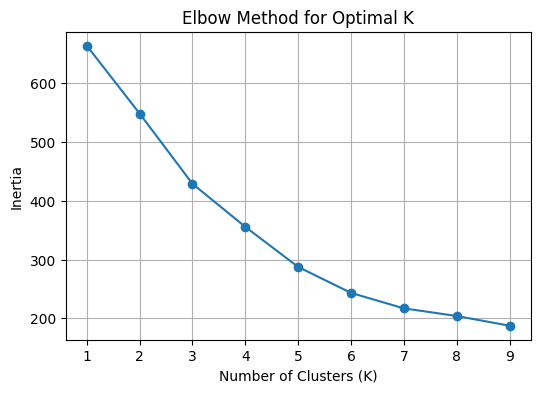

In [9]:
# Select relevant features for clustering
features = customer_df[['total_spent', 'avg_rating', 'most_used_payment', 'most_common_weekday']]

# 1. Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 2. Determine optimal number of clusters (Elbow Method)
inertia = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


Elbow Method Interpretation
Looking at the graph, the elbow is clearly visible around:

K = 3

After K=3, the decrease in inertia becomes more gradual — this suggests that adding more clusters brings diminishing returns.

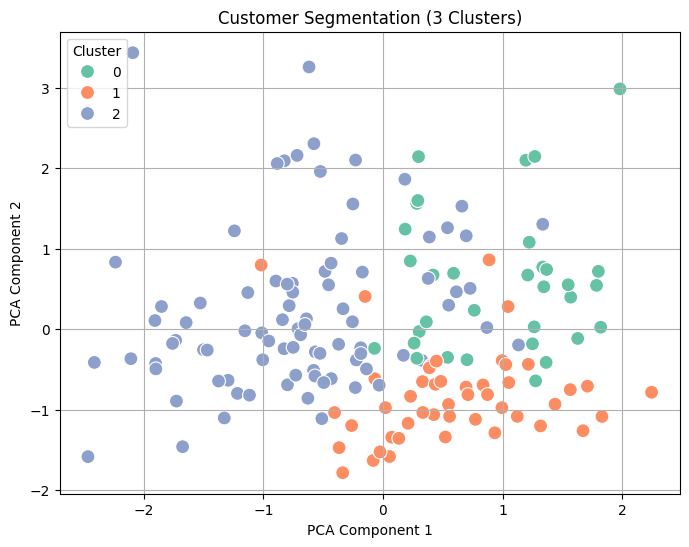

In [10]:
# Apply KMeans with the optimal number of clusters (K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['cluster'] = kmeans.fit_predict(scaled_features)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)
customer_df['pca_1'] = components[:, 0]
customer_df['pca_2'] = components[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_df, x='pca_1', y='pca_2', hue='cluster', palette='Set2', s=100)
plt.title('Customer Segmentation (3 Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

The customer segmentation was successfully created using KMeans with 3 clusters and visualized the results using PCA. Now we proceed to analyse and describe each cluster based on the customer behaviour.

In [12]:
print(customer_df.columns.tolist())


['customer_id', 'total_spent', 'avg_spent', 'avg_rating', 'most_used_payment', 'most_common_weekday', 'cluster', 'pca_1', 'pca_2']


In [11]:
# Group by cluster and summarize key variables
cluster_summary = customer_df.groupby('cluster')[[
    'purchased_amount_(usd)', 'review_rating', 'product_category', 'purchase_frequency'
]].agg(['mean', 'median', 'count'])

display(cluster_summary)


KeyError: "Columns not found: 'purchase_frequency', 'product_category', 'purchased_amount_(usd)', 'review_rating'"